<a href="https://colab.research.google.com/github/keedjk7/Machine-Learning/blob/main/Activity10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense,LSTM

#10.1 Data Preparation

## 10.1.1 Load and Prepare Data

In [ ]:
ACC = pd.read_csv('/content/drive/MyDrive/Colab Data/acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('/content/drive/MyDrive/Colab Data/heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('/content/drive/MyDrive/Colab Data/labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [ ]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()


print('ACC start: ',ACC_min_date ,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date ,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date ,'SleepL end: ',SleepL_max_date)

ACC start:  -124489.16105 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [ ]:
#set start timedelta
start_timedelta = 0
#set end timedelta
end_timedelta = 16980

ACC_new = ACC[(ACC['timedelta'] >= start_timedelta) &(ACC['timedelta'] <= end_timedelta) ]
HeartR_new = HeartR[(HeartR['timedelta'] >= start_timedelta) &(HeartR['timedelta'] <= end_timedelta) ]
SleepL_new = SleepL[(SleepL['timedelta'] >= start_timedelta) &(SleepL['timedelta'] <= end_timedelta) ]

In [ ]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

#เวลาที่ duplicate ให้ปัดเป็น mean 
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

ACC_new2 = pd.concat([df_acc_X, df_acc_Y['accY'], df_acc_Z['accZ']], axis=1)
ACC_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [ ]:
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [ ]:
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:00,-1.0
0 days 00:00:01,-1.0
0 days 00:00:02,-1.0
0 days 00:00:03,-1.0
0 days 00:00:04,-1.0
...,...
0 days 04:42:56,0.0
0 days 04:42:57,0.0
0 days 04:42:58,0.0


In [ ]:
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [ ]:
count_check =df.isnull().sum()
count_check

timedelta    0
accX         0
accY         0
accZ         0
heartrate    8
sleep        0
dtype: int64

In [ ]:
fillHeartRate = df['heartrate'].median()
df['heartrate']=df['heartrate'].fillna(fillHeartRate)

In [ ]:
re_check =df.isnull().sum()
re_check

timedelta    0
accX         0
accY         0
accZ         0
heartrate    0
sleep        0
dtype: int64

In [ ]:
df = df.drop(columns = ['timedelta'])
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,82.0,-1.0
1,-0.240757,0.873826,0.415446,82.0,-1.0
2,-0.244620,0.883943,0.387026,82.0,-1.0
3,-0.248036,0.902427,0.347812,82.0,-1.0
4,-0.241778,0.912946,0.321502,82.0,-1.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [ ]:
feature_columns = ['accX','accY','accZ','heartrate']
label_columns = ['sleep']

df_feature = df[feature_columns]
df_label = df[label_columns]
#standardized
standard_scaler = StandardScaler()
afterScaler = standard_scaler.fit_transform(df_feature)

afterScaler

array([[-0.58754699,  3.05807519,  0.69872824,  0.14353909],
       [-0.58145574,  2.99509378,  0.75774575,  0.14353909],
       [-0.59107524,  3.02466836,  0.72269623,  0.14353909],
       ...,
       [-1.08151136, -1.0942955 ,  1.13827323, -0.63045529],
       [-1.08325986, -1.09644011,  1.13736319, -0.63045529],
       [-1.08423404, -1.09676929,  1.13663908, -0.63045529]])

In [ ]:
df_feature = pd.DataFrame(data = afterScaler, index = df_feature.index, columns = feature_columns)
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.143539
1,-0.581456,2.995094,0.757746,0.143539
2,-0.591075,3.024668,0.722696,0.143539
3,-0.599581,3.078699,0.674335,0.143539
4,-0.583998,3.109450,0.641889,0.143539
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630455
16977,-1.082531,-1.095348,1.137542,-0.630455
16978,-1.081511,-1.094296,1.138273,-0.630455
16979,-1.083260,-1.096440,1.137363,-0.630455


In [ ]:
df_label.replace(-1,0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


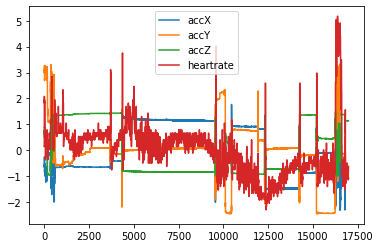

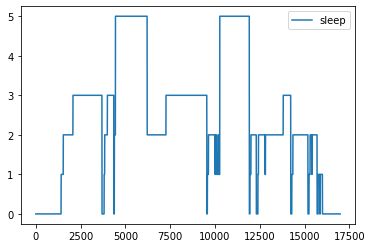

In [ ]:
df_feature.plot(), df_label.plot()
plt.show()

##10.1.2 Simple Moving Average (SMA) and Create 2D feature

In [ ]:
# ------------Simple Moving Average (SMA) ------------------------------
#columns=['accX', 'accY', 'accZ', 'heartrate']
df_feature_SMA = pd.DataFrame(columns=['accX','accY','accZ','heartrate'])
df_feature_SMA['accX'] = df_feature['accX'].rolling(5, min_periods=1).mean()
df_feature_SMA['accY'] = df_feature['accY'].rolling(5, min_periods=1).mean()
df_feature_SMA['accZ'] = df_feature['accZ'].rolling(5, min_periods=1).mean()
df_feature_SMA['heartrate'] = df_feature['heartrate'].rolling(5, min_periods=1).mean()

In [ ]:
# ------------ Train-Test-Split 2D features -------------------------------
# set sliding window parameter
slidingW = 100 #จำนวน row
stride_step = 5
n_features = 4 
df_feature2D = np.array([],ndmin=1)
df_feature2D_T = np.array([])
df_label_new = np.array([])

for t in range(0 , len(df_feature), stride_step ):
    F2d = np.array(df_feature[t:t+slidingW],ndmin=1)
    if len(F2d) <slidingW:
        break
    # F2d.reshape(slidingW, n_features,1)
    F2d_T = F2d.transpose()
    # print(df_feature3D.shape)
    # print(F3d.shape)
    if df_feature2D.size == 0 :
        df_feature2D = F2d
        df_feature2D_T =F2d_T
    else:
        df_feature2D = np.dstack((df_feature2D,F2d))
        df_feature2D_T = np.dstack((df_feature2D_T,F2d_T))
    Labels = stats.mode(df_label[t : t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])

df_feature2D = df_feature2D.transpose()
df_feature2D = df_feature2D[..., np.newaxis]
df_feature2D_T = df_feature2D_T.transpose()
df_feature2D_T = df_feature2D_T[..., np.newaxis]

In [ ]:
df_feature2D.shape,df_feature2D_T.shape,df_label_new.shape

((3377, 4, 100, 1), (3377, 100, 4, 1), (3377,))

## 10.1.3Train Test Split

In [ ]:
# ------------ Train-Test-Split 2D features -------------------------------
seed = 77
X_train_1, X_test_1, Y_train_1, Y_test_1 = model_selection.train_test_split(df_feature2D,df_label_new,test_size = 0.3, random_state=seed)

In [ ]:
# ------------ Train-Test-Split 2D features -------------------------------
seed = 77
X_train_2, X_test_2, Y_train_2, Y_test_2 = model_selection.train_test_split(df_feature2D_T,df_label_new,test_size = 0.3, random_state=seed)

#10.2 LSTM Model Training and Testing

##10.2.1 LSTM Model Parameters

In [ ]:
# ------------ LSTM Architecture parameter -------------------------------
LSTM_L1 = 100 # try 200, 300, 400, 500, 1000
LSTM_L2 = 50 # try 50, 100, 150, 200, 250, 300
dropRate_L1 = 0.25
dropRate_L2 = 0.5
D_out = 5
Activation = "softmax"
n_classes = 6
Input_shape1 = (n_features, slidingW)
Input_shape2 = (slidingW, n_features)
# Nlayer(LSTM_L1, Dense), Nnode, Activation

# try
#Option #1:
inRow = n_features
inCol = slidingW
# Option #2
inRow = slidingW
inCol = slidingW

##10.2.2 LSTM Model Train Test

In [ ]:
# ------------ Create LSTM Model -------------------------------
model =  tf.keras.Sequential()
model.add( LSTM( LSTM_L1, return_sequences=True,
input_shape=Input_shape1))
model.add(Dropout(dropRate_L1 ))
model.add(LSTM(LSTM_L2))
model.add(Dropout(dropRate_L2))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4, 100)            80400     
                                                                 
 dropout_8 (Dropout)         (None, 4, 100)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 6)                 306       
                                                                 
Total params: 110,906
Trainable params: 110,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ------------ Create LSTM Model -------------------------------
model2 =  tf.keras.Sequential()
model2.add( LSTM( LSTM_L1, return_sequences=True,
input_shape=Input_shape2))
model2.add(Dropout(dropRate_L1 ))
model2.add(LSTM(LSTM_L2))
model2.add(Dropout(dropRate_L2))
model2.add(Dense(n_classes, activation='softmax'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100, 100)          42000     
                                                                 
 dropout_10 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 306       
                                                                 
Total params: 72,506
Trainable params: 72,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',
loss= "sparse_categorical_crossentropy",metrics=["acc"])

In [ ]:
print(X_train_1.shape)
print(X_test_1.shape)
print(Y_train_1.shape)
print(Y_test_1.shape)

(2363, 4, 100, 1)
(1014, 4, 100, 1)
(2363,)
(1014,)


In [ ]:
# ------ Train CNN using 2D feature--------------------------------------------
# Training the model
EP = 50
batch_size = 100 # try 20, 40, 60, 80, 100
history = model.fit( X_train_1, Y_train_1, # try Option #1 และ Option #2
batch_size = batch_size,
validation_data=(X_test_1, Y_test_1), epochs=EP)

Epoch 1/50
24/24 [==============================] - 7s 73ms/step - loss: 1.4457 - acc: 0.4287 - val_loss: 1.1529 - val_acc: 0.5276
Epoch 2/50
24/24 [==============================] - 1s 26ms/step - loss: 1.1520 - acc: 0.5167 - val_loss: 1.0038 - val_acc: 0.5552
Epoch 3/50
24/24 [==============================] - 1s 26ms/step - loss: 1.0134 - acc: 0.5933 - val_loss: 0.8769 - val_acc: 0.6657
Epoch 4/50
24/24 [==============================] - 1s 29ms/step - loss: 0.8918 - acc: 0.6475 - val_loss: 0.7471 - val_acc: 0.7199
Epoch 5/50
24/24 [==============================] - 1s 27ms/step - loss: 0.7720 - acc: 0.6923 - val_loss: 0.6630 - val_acc: 0.7564
Epoch 6/50
24/24 [==============================] - 1s 27ms/step - loss: 0.7038 - acc: 0.7325 - val_loss: 0.5834 - val_acc: 0.7801
Epoch 7/50
24/24 [==============================] - 1s 27ms/step - loss: 0.6430 - acc: 0.7545 - val_loss: 0.5283 - val_acc: 0.7899
Epoch 8/50
24/24 [==============================] - 1s 27ms/step - loss: 0.5869 - a

In [ ]:
print(X_train_2.shape)
print(X_test_2.shape)
print(Y_train_2.shape)
print(Y_test_2.shape)

(2363, 100, 4, 1)
(1014, 100, 4, 1)
(2363,)
(1014,)


In [ ]:
# ------------ Create Optimizer -------------------------------
model2.compile(optimizer='adam',
loss= "sparse_categorical_crossentropy",metrics=["acc"])

In [ ]:
# ------ Train CNN using 2D feature--------------------------------------------
# Training the model
EP = 50
batch_size = 10 # try 20, 40, 60, 80, 100
history2 = model2.fit( X_train_2, Y_train_2, # try Option #1 และ Option #2
batch_size = batch_size,
validation_data=(X_test_2, Y_test_2), epochs=EP)

Epoch 1/50
237/237 [==============================] - 32s 116ms/step - loss: 1.0999 - acc: 0.5442 - val_loss: 0.8416 - val_acc: 0.6617
Epoch 2/50
237/237 [==============================] - 25s 104ms/step - loss: 0.9407 - acc: 0.6030 - val_loss: 0.9651 - val_acc: 0.5799
Epoch 3/50
237/237 [==============================] - 25s 105ms/step - loss: 0.8008 - acc: 0.6682 - val_loss: 0.8378 - val_acc: 0.6716
Epoch 4/50
237/237 [==============================] - 25s 104ms/step - loss: 0.7610 - acc: 0.6813 - val_loss: 0.7687 - val_acc: 0.6972
Epoch 5/50
237/237 [==============================] - 25s 104ms/step - loss: 0.7201 - acc: 0.6890 - val_loss: 0.6148 - val_acc: 0.7426
Epoch 6/50
237/237 [==============================] - 25s 106ms/step - loss: 0.7479 - acc: 0.7127 - val_loss: 0.6187 - val_acc: 0.7456
Epoch 7/50
237/237 [==============================] - 25s 105ms/step - loss: 0.7904 - acc: 0.7063 - val_loss: 0.6302 - val_acc: 0.7051
Epoch 8/50
237/237 [==============================] - 2

#10.3 LSTM Performance Measurement

In [ ]:
from sklearn import utils

In [ ]:
LSTM_pred = model.predict(X_test_1)

32/32 [==============================] - 1s 5ms/step


In [ ]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print(utils.multiclass.type_of_target(LSTM_pred))

continuous-multioutput


In [ ]:
LSTM_pred1 = np.argmax(model.predict(X_test_1),axis=1)
LSTM_pred2 = np.argmax(model2.predict(X_test_2),axis=1)
print(utils.multiclass.type_of_target(LSTM_pred1))
print(utils.multiclass.type_of_target(LSTM_pred2))

32/32 [==============================] - 2s 39ms/step
multiclass
multiclass


In [ ]:
######## Option 1
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('Confusion Matrix of LSTM 1 model: ')
print(confusion_matrix(Y_test_1,LSTM_pred1))
print('Classification Report of LSTM 1 model: ')
print(classification_report(Y_test_1,LSTM_pred1))

Confusion Matrix of LSTM 1 model: 
[[158   0   5   0   0]
 [ 10  24  11   0   0]
 [  9   1 273   5  11]
 [  0   0   7 264   0]
 [  0   0   0   0 236]]
Classification Report of LSTM 1 model: 
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       163
         1.0       0.96      0.53      0.69        45
         2.0       0.92      0.91      0.92       299
         3.0       0.98      0.97      0.98       271
         5.0       0.96      1.00      0.98       236

    accuracy                           0.94      1014
   macro avg       0.94      0.88      0.90      1014
weighted avg       0.94      0.94      0.94      1014



In [ ]:
######## Option 2
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('Confusion Matrix of LSTM 2 model: ')
print(confusion_matrix(Y_test_2,LSTM_pred2))
print('Classification Report of LSTM 2 model: ')
print(classification_report(Y_test_2,LSTM_pred2))

Confusion Matrix of LSTM 2 model: 
[[147   2  14   0   0]
 [ 10  20  15   0   0]
 [  2   9 282   6   0]
 [  0   0  83 187   1]
 [  0   0   5   0 231]]
Classification Report of LSTM 2 model: 
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       163
         1.0       0.65      0.44      0.53        45
         2.0       0.71      0.94      0.81       299
         3.0       0.97      0.69      0.81       271
         5.0       1.00      0.98      0.99       236

    accuracy                           0.86      1014
   macro avg       0.85      0.79      0.81      1014
weighted avg       0.88      0.86      0.85      1014



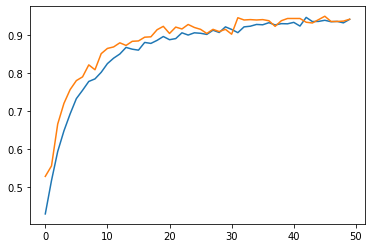

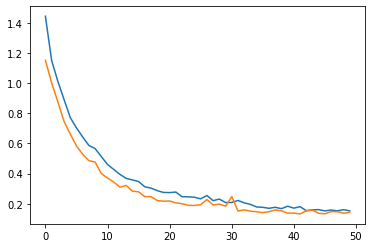

In [ ]:
######## Option 1
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

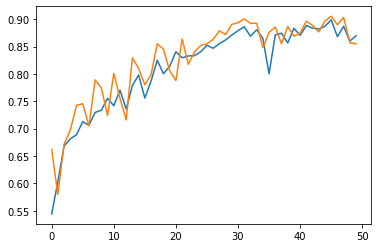

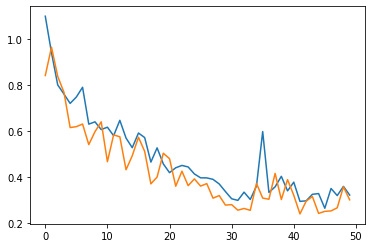

In [ ]:
######## Option 2
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.show()
# View Loss Graph
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.show()